# Nonlinear Pricing

Based on code by Luo, Perrigne, and Vuong (2018, Journal of Political Economy)

In [34]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from dataclasses import dataclass
# check whether LaTeX is installed on computer

latex_installed = False

## Set Parameters

In [35]:
from scipy.optimize import fsolve

class Parameters:
    # Specify parameters
    beta = 0.5
    K = 5  # fixed cost
    r = 0.05  # marginal cost
    b = 2.0  # [CHOOSE TYPE DISTRIBUTION FUNCTION]
    w = 1.0
    Ncut = 1000
    alpha = np.arange(1/Ncut, 1 + 1/Ncut, 1/Ncut)
    k0H, k1H, k0q, k1q, theta0 = 0, 0, 0, 0, 0
    Nobs = 0

    def update(self):
        m = self
        self.xx = np.arange(m.w, m.w + 1, 0.0001)
        self.xx = self.xx[:-1]

        # Some useful numbers defined by parameters
        m.k0H = -(1 + m.w) / m.b
        m.k1H = 1 + 1 / m.b
        m.k0q = (m.beta / m.r) * m.k0H
        m.k1q = (m.beta / m.r) * m.k1H

        # Find the cutoff type
        if m.Mfun(m.w) >= 0:
            m.theta0 = m.w
        else:
            m.theta0 = fsolve(lambda u: m.Mfun(u), m.w + 0.5)



    # Functions generated by our distribution
    def Ffun(m, x): return 1 - ((1 - (x - m.w)) ** m.b)  # original distribution
    def ffun(m, x): return m.b * ((1 - (x - m.w)) ** (m.b - 1))  # original density
    def Hfun(m, x): return m.k0H + m.k1H * x  # theta - (1-F)/f
    def Ufun(m, x): return x ** m.beta  # u0 = q^beta

    # Eqm mappings
    def q_theta(m, x): return (m.k0q + m.k1q * x) ** (1 / (1 - m.beta))  # q(theta)
    def theta_q(m, q): return (-m.k0q + q ** (1 - m.beta)) / m.k1q  # theta(q)
    def thetaP_q(m, q): return (1 - m.beta) * (q ** (-m.beta)) / m.k1q

    def Mfun(m, x): return m.Hfun(x) * (m.q_theta(x) ** m.beta) - (m.K + m.r * m.q_theta(x))  # M(theta)

    # Check the M function that defines the cutoff type
    # plt.plot(xx, Mfun(xx))


    # Payment schedule in direct mechanism
    def t_theta(m, x): return x * (m.q_theta(x) ** m.beta) - \
        ((1 - m.beta) / m.k1q) * (
                (m.k0q + m.k1q * x) ** (1 / (1 - m.beta)) -
                (m.k0q + m.k1q * m.theta0) ** (1 / (1 - m.beta))
        )

    # Tariff function in indirect mechanism
    def Tfun(m, q): return m.theta_q(q) * (q ** m.beta) - \
        ((1 - m.beta) / m.k1q) * (
                (m.k0q + m.k1q * m.theta_q(q)) ** (1 / (1 - m.beta)) -
                (m.k0q + m.k1q * m.theta0) ** (1 / (1 - m.beta))
        )

    # Marginal tariff function
    def TPfun(m, q): return m.theta_q(q) * m.beta * (q ** (m.beta - 1)) + \
        (q ** m.beta - ((m.k0q + m.k1q * m.theta_q(q)) ** (1 / (1 - m.beta) - 1))) * m.thetaP_q(q)

    # Truncated distribution function
    def Fstar(m, x): return (m.Ffun(x) - m.Ffun(m.theta0)) / (1 - m.Ffun(m.theta0))

    # Truncated density function
    def fstar(m, x): return m.ffun(x) / (1 - m.Ffun(m.theta0))

    # TRUE type quantile function (conditioning on purchasing)
    def theta_alpha(m, a): return 1 + m.w - \
        (1 - ((1 - m.Ffun(m.theta0)) * m.alpha + m.Ffun(m.theta0))) ** (1 / m.b)


In [36]:
m = Parameters()
m.update()

## Define Auxiliary Functions

In [37]:
def alpha_fun1(theta, m: Parameters):
    """
    Calculate the corresponding quantile alpha for theta
    """
    
    a_hat = np.arange(1/m.Nobs, 1 + 1/m.Nobs, 1/m.Nobs)
    theta_hat = m.theta0 * theta_fun1(a_hat, m)
    
    J0 = np.sum(np.tile(theta, (m.Nobs, 1)) >= np.tile(theta_hat[:, np.newaxis], (1, len(theta))), axis=0)
    J = J0 + 1
    
    J0 = np.arange(1, m.Nobs)
    
    # Integration of each bin: J = 1,..., N-1 
    intJ = (1 - m.r_hat / m.Tp_obs[J0]) * (-np.log(1 - J0 / m.Nobs) + np.log(1 - (J0 - 1) / m.Nobs))
    
    k0 = m.Tp_obs[-1] - m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])
    k1 = m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])
    
    theta = theta / m.theta0
    alpha0 = theta.copy()
    
    for i in range(len(theta)):
        if J[i] == 0:
            alpha0[i] = 0
        elif J[i] == 1:
            alpha0[i] = 1 - np.exp(np.log(theta[i]) / (-(1 - m.r_hat / m.Tp_obs[0])))
        elif 2 <= J[i] <= m.Nobs - 1:
            alpha0[i] = 1 - np.exp(np.log(1 - (J[i] - 1) / m.Nobs) - (np.log(theta[i]) - np.sum(intJ[:J[i] - 1])) / (1 - m.r_hat / m.Tp_obs[J[i]]))
        else:  # J[i] = N
            alpha0[i] = (m.Tp_obs[-2] / np.exp(np.log(theta[i]) - np.sum(intJ)) - k0) / k1
            
    return alpha0


In [38]:
def theta_fun1(alpha, m: Parameters):
    """
    Normalize theta_cut = 1, estimate type quantile function
    This estimates T'(q(alpha)) using our new estimator
    """
    
    J = np.ceil(m.Nobs * alpha)
    J0 = np.arange(1, m.Nobs)
    
    # Integration of each bin: J = 1,..., N-1
    intJ = (1 - m.r_hat / m.Tp_obs[J0]) * (-np.log(1 - J0 / m.Nobs) + np.log(1 - (J0 - 1) / m.Nobs))
    
    k0 = m.Tp_obs[-1] - m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])
    k1 = m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])
    
    theta = alpha.copy()
    
    for i in range(len(alpha)):
        if J[i] == 0:
            theta[i] = 1
        elif J[i] == 1:
            theta[i] = np.exp(-(1 - m.r_hat / m.Tp_obs[0]) * np.log(1 - alpha[i]))
        elif 2 <= J[i] <= m.Nobs - 1:
            temp1 = (1 - m.r_hat / m.Tp_obs[int(J[i])]) * (-np.log(1 - alpha[i]) + np.log(1 - (J[i] - 1) / m.Nobs))
            theta[i] = np.exp(np.sum(intJ[:int(J[i]) - 1]) + temp1)
        else:  # J[i] = N
            temp2 = np.log(m.Tp_obs[-2] / (k0 + k1 * alpha[i]))
            theta[i] = np.exp(np.sum(intJ) + temp2)
    
    return theta


In [39]:
@dataclass
class Results:
    results_f1: npt.NDArray
    theta_truth: npt.NDArray
    theta_max: npt.NDArray
    f_truth: npt.NDArray
    results_up1: npt.NDArray
    q_truth: npt.NDArray
    Up_truth: npt.NDArray

In [40]:
def make_fig(r: Results):
    # Set default text interpreter to LaTeX if installed
    plt.rc('text', usetex=latex_installed)
    
    # Plot REPORT A
    plt.subplot(1, 2, 1)
    a1 = np.quantile(r.results_f1, 0.05, axis=0)
    a2 = np.mean(r.results_f1, axis=0)
    a3 = np.quantile(r.results_f1, 0.95, axis=0)

    for i in range(len(r.theta_truth)):
        f1_temp = r.results_f1[:, i]
        f1_temp = f1_temp[r.theta_truth[i] <= r.theta_max.reshape(-1)]
        if len(f1_temp) > 0:
            a1[i] = np.quantile(f1_temp, 0.05)  # 5% quantile
            a2[i] = np.mean(f1_temp)  # mean
            a3[i] = np.quantile(f1_temp, 0.95)  # 95% quantile
        else:
            a1[i] = r.f_truth[i]
            a2[i] = a1[i]
            a3[i] = a1[i]

    plt.plot(r.theta_truth, r.f_truth, '-.r', r.theta_truth, a1, ':k', r.theta_truth, a2, '--b', r.theta_truth, a3, ':k', linewidth=1.25)
    plt.axis([0.95 * np.min(r.theta_truth), 2, 0.75 * np.min(r.f_truth), 1.25 * np.max(r.f_truth)])
    plt.title(r'$\widehat{f}(\cdot)$')
    plt.xlabel(r'$\theta$')

    # Plot REPORT B
    plt.subplot(1, 2, 2)
    a1 = np.quantile(r.results_up1, 0.05, axis=0)
    a2 = np.mean(r.results_up1, axis=0)
    a3 = np.quantile(r.results_up1, 0.95, axis=0)

    plt.plot(r.q_truth, r.Up_truth, '-.r', r.q_truth, a1, ':k', r.q_truth, a2, '--b', r.q_truth, a3, ':k', linewidth=1.25)
    plt.axis([0.95 * np.min(r.q_truth), 1.05 * np.max(r.q_truth), 0.95 * np.min(r.Up_truth), 1.05 * np.max(r.Up_truth)])
    plt.title(r'$\widehat{U_{0Q}}(\cdot)$')
    plt.xlabel(r'$Q$')

    # Save figure
    plt.savefig(f'b{m.b}Nobs{m.Nobs}.jpg')
    plt.show()


## Run Monte Carlo Simulation

In [41]:
import time

# Clear console
from IPython.display import clear_output

def run_montecarlo(m: Parameters):
    # Set random seed
    np.random.seed(888)

    # Number of replications
    nREP = 20  # Change to 1000 if needed

    # Load model predicted functions and parameters from NLPmodel.py
    #from NLPmodel import *

    print('Running Monte Carlo simulation')
    all_results = []

    # Perform Monte Carlo simulation
    for iSIZE in range(1, 4):
        m.Nobs = 250 * (4 ** (iSIZE - 1))
        start_time = time.time()
        print('\nNumber of observations: ', m.Nobs)

        results_f1 = np.zeros((nREP, len(np.arange(m.theta0, 2, 1 / m.Ncut))))
        results_theta1 = np.zeros((nREP, len(np.arange(m.theta0, 2, 1 / m.Ncut))))
        results_up1 = np.zeros((nREP, len(np.arange(m.theta0, 2, 1 / m.Ncut))))
        results_r = np.zeros((nREP, 1))
        results_K = np.zeros((nREP, 1))
        theta_max = np.zeros((nREP, 1))

        for iREP in range(1, nREP + 1):
            if iREP % 100 == 0:
                clear_output(wait=True)
                print(iREP)

            # DGP: Generate Data
            u = np.random.rand(m.Nobs * 100, 1)
            theta = 1 - ((1 - u) ** (1 / m.b)) + m.w
            theta = theta[theta >= m.theta0][:m.Nobs]
            theta = np.sort(theta)
            m.q_obs = m.q_theta(theta)

            # Equation (10): Estimate marginal cost
            Q_max = np.max(m.q_obs) + 1.06 * np.std(m.q_obs) * ((1 / len(m.q_obs)) ** (1 / 5))
            m.r_hat = m.TPfun(Q_max)
            m.q_min = np.min(m.q_obs)
            m.K_hat = m.r_hat * (m.Tfun(m.q_min) / m.TPfun(m.q_min) - m.q_min)

            results_r[iREP - 1] = m.r_hat
            results_K[iREP - 1] = m.K_hat

            # Equation (11): Type quantile function
            m.K1TP = m.Nobs * (m.TPfun(m.q_obs[1:]) - m.TPfun(m.q_obs[:-1]))
            m.K0TP = m.TPfun(m.q_obs[1:]) - (np.arange(2, m.Nobs + 1) * (m.K1TP / m.Nobs))
            m.Tp_obs = m.TPfun(m.q_obs)

            theta_truth = np.arange(m.theta0, 2, 1 / m.Ncut)
            alpha_truth = alpha_fun1(theta_truth, m)
            q_truth = m.q_theta(theta_truth)
            m.J = np.ceil(m.Nobs * alpha_truth)

            theta_hat1 = m.theta0 * theta_fun1(alpha_truth, m)
            theta_max[iREP - 1] = m.theta0 * theta_fun1(np.array([1.]), m)

            # Equation (13): Type density function, marginal utility
            k0 = m.Tp_obs[-1] - m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])
            k1 = m.Nobs * (m.Tp_obs[-1] - m.Tp_obs[-2])

            f_hat1 = np.zeros_like(alpha_truth)
            Up_hat1 = np.zeros_like(alpha_truth)

            for i in range(len(alpha_truth)):
                if m.J[i] == 0:
                    Tp = m.Tp_obs[0]
                elif 1 <= m.J[i] <= m.Nobs - 1:
                    Tp = m.Tp_obs[int(m.J[i])]
                else:
                    Tp = k0 + k1 * alpha_truth[i]

                f_hat1[i] = (1 / theta_hat1[i]) * (1 - alpha_truth[i]) * (Tp / (Tp - m.r_hat))

                if alpha_truth[i] == 1 and Dr_true == 0:
                    f_hat1[i] = (Tp / theta_hat1[i]) * (-1 / k1)

                Up_hat1[i] = Tp / theta_hat1[i]

            f_truth = m.fstar(theta_truth)
            Up_truth = m.beta * (q_truth ** (m.beta - 1))

            results_f1[iREP - 1, :] = f_hat1
            results_theta1[iREP - 1, :] = theta_hat1
            results_up1[iREP - 1, :] = Up_hat1
        
        results = Results(results_f1=results_f1, theta_truth=theta_truth,
                          theta_max=theta_max, f_truth=f_truth, results_up1=results_up1,
                          q_truth=q_truth, Up_truth=Up_truth)

        make_fig(results)
        print(f'Time elapsed for size {m.Nobs}: {time.time() - start_time:.2f} seconds')
        all_results.append(results)
    return all_results


Running Monte Carlo simulation

Number of observations:  250


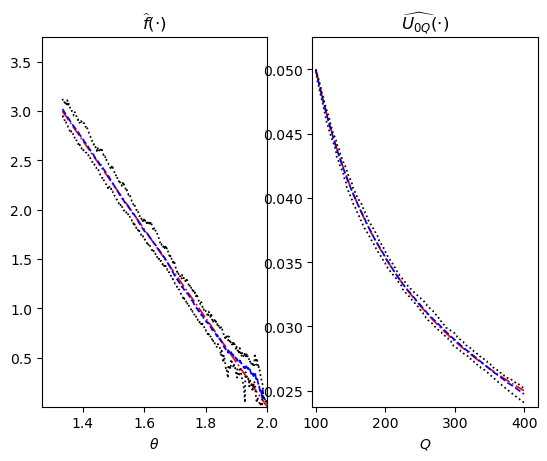

Time elapsed for size 250: 0.64 seconds

Number of observations:  1000


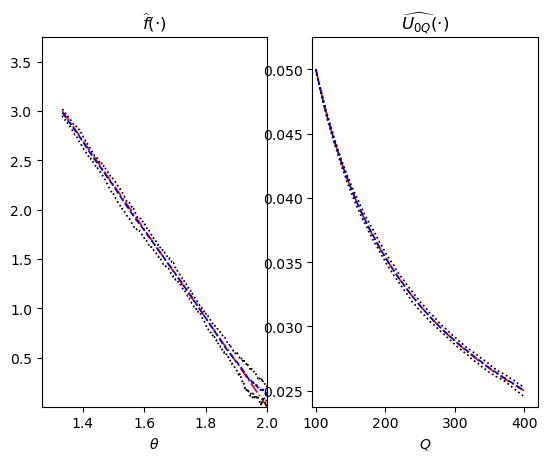

Time elapsed for size 1000: 1.05 seconds

Number of observations:  4000


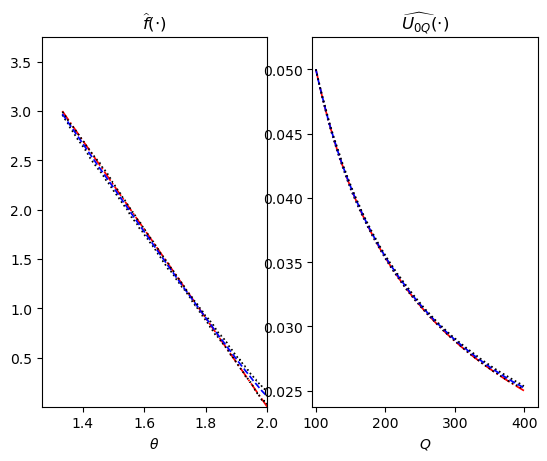

Time elapsed for size 4000: 1.88 seconds


In [42]:
all_results = run_montecarlo(m)
results = all_results[-1] # save results of last Monte Carlo run in results variable

## Exercises

### Exercise 1

Run the above Monte Carlo simulation.

Plot the cost function.

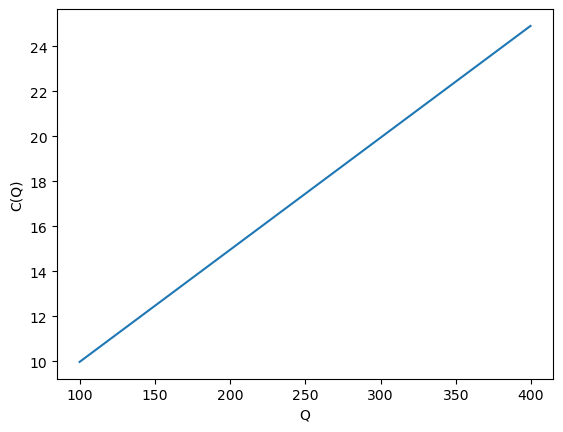

In [43]:
plt.plot(results.q_truth, m.K_hat + m.r_hat*results.q_truth)
plt.xlabel('Q')
plt.ylabel('C(Q)');

Run the above Monte Carlo simulation with true density $f(\theta)=1$ for $\theta\in [1,2]$.

In [44]:
m2 = Parameters()
m2.b = 1.1
m2.update()

Running Monte Carlo simulation

Number of observations:  250


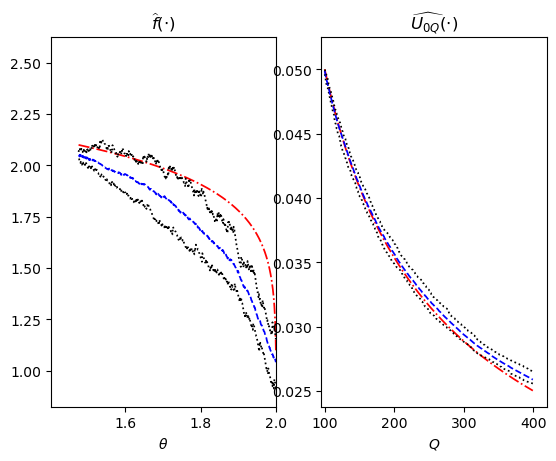

Time elapsed for size 250: 0.59 seconds

Number of observations:  1000


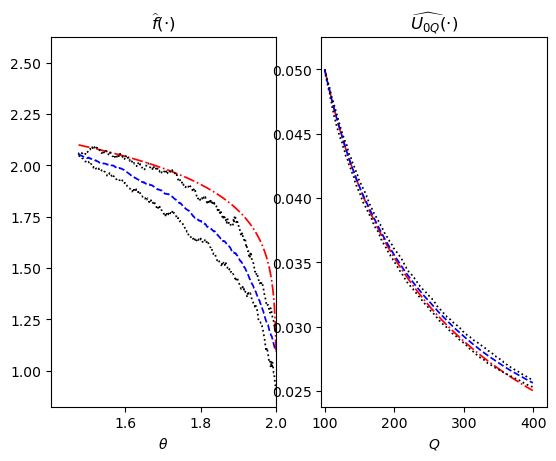

Time elapsed for size 1000: 0.81 seconds

Number of observations:  4000


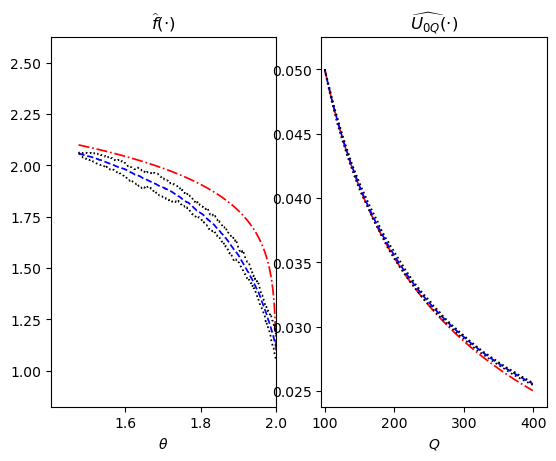

Time elapsed for size 4000: 1.98 seconds


In [45]:
all_results2 = run_montecarlo(m2)

### Exercise 2

Use the results from the original specification of Luo, Perrigne, and Vuong.

What happens if you introduce a tax $\tau Q$ with $\tau=0.01$? Calculate based on the estimated density $\hat f$ and utility function $\widehat{U_{0Q}}$.

In [46]:
f_hat = np.mean(results.results_f1, axis=0)
up_hat = np.mean(results.results_up1, axis=0)

In [47]:
F_hat = np.cumsum(f_hat)/np.sum(f_hat)

In [48]:
up_interp =scipy.interpolate.interp1d(
    results.q_truth, up_hat, fill_value='extrapolate', kind='linear')

Find $Q(\theta)$ by solving the first-order condition
$$
\theta U'(Q(\theta)) - C'(Q(\theta)) - \tau - \frac{1-F(\theta)}{f(\theta)} U'(Q(\theta)) = 0
$$
for each $\theta$.

In [49]:
q_solution = np.zeros_like(results.theta_truth)

In [50]:
tau = 0.01

In [51]:

for i in range(len(q_solution)):
    solution_foc = scipy.optimize.fsolve(lambda q: results.theta_truth[i]*up_interp(q) - m.r_hat - tau - (1-F_hat[i])/f_hat[i]*up_interp(q), 
                                         x0=results.q_truth.mean())

    q_solution[i] = solution_foc[0]



C:\Users\fares\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Find $\theta^*$ by solving
$$
\theta^* U(Q(\theta^*)) - C(Q(\theta^*)) - \tau Q(\theta^*) - \frac{1-F(\theta^*)}{f(\theta^*)} U(Q(\theta^*)) = 0.
$$

In [52]:

U_Q_star_pretax = m.r_hat/(m.theta0-(1-F_hat[0])/f_hat[0])

In [53]:

q_diff = np.concatenate(([np.diff(results.q_truth)[0]], np.diff(results.q_truth)))
u_hat = U_Q_star_pretax + np.cumsum(q_diff * up_hat)
u_interp =scipy.interpolate.interp1d(
    results.q_truth, u_hat, fill_value='extrapolate', kind='linear')

In [54]:
q_interp = scipy.interpolate.interp1d(results.theta_truth, q_solution, fill_value='extrapolate', kind='linear')
f_interp = scipy.interpolate.interp1d(results.theta_truth, f_hat, fill_value='extrapolate', kind='linear')
F_interp = scipy.interpolate.interp1d(results.theta_truth, F_hat, fill_value='extrapolate', kind='linear')

In [55]:

theta0new = scipy.optimize.fsolve(
    lambda theta: theta*u_interp(q_interp(theta)) - m.r_hat - tau - (1-F_interp(theta))/f_interp(theta)*u_interp(q_interp(theta)),
                                         x0=m.theta0)[0]

In [56]:
q_interp(theta0new), q_interp(m.theta0), results.q_truth[0]

(array(99.7013372), array([60.34648134]), 100.0)

In [57]:
above_theta0new = q_solution>=q_interp(theta0new)

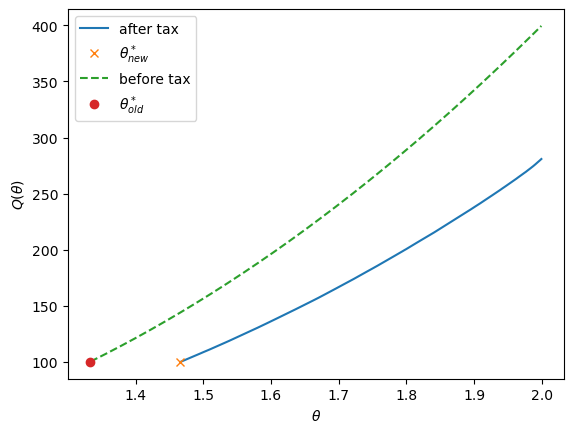

In [58]:
plt.plot(results.theta_truth[above_theta0new], q_solution[above_theta0new], '-', label='after tax')
plt.plot(theta0new, q_interp(theta0new), 'x', label=r'$\theta^*_{new}$')
plt.plot(results.theta_truth, results.q_truth, '--', label='before tax')
plt.plot(m.theta0, results.q_truth[0], 'o', label=r'$\theta^*_{old}$')
plt.xlabel('$\\theta$')
plt.ylabel('$Q(\\theta)$')
plt.legend();

Derive the optimal tariff of the monopolist.

Denote the consumer's utility as
$$
V(\theta) = \theta U_0(Q(\theta)) - T(Q(\theta))
$$
By an envelope theorem argument, $V'(\theta)=U_0(Q(\theta))$ and
$$
V(\theta) = \int_{\theta^*}^\theta U_0(Q(x)) dx
$$
This gives us the equation for the tariff:
$$
T(Q(\theta)) = \theta U_0(Q(\theta)) - \underbrace{\int_{\theta^*}^\theta U_0(Q(x)) dx}_{=V(\theta)}
$$


In [59]:
V = np.cumsum(u_hat)*(results.theta_truth[1]-results.theta_truth[0])
T = results.theta_truth*u_hat - V

In [60]:
len(T)


667

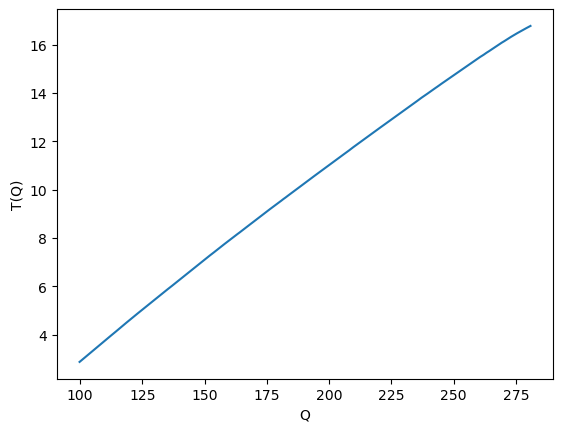

In [61]:
plt.plot(q_solution[above_theta0new], T[above_theta0new])
plt.xlabel('Q')
plt.ylabel('T(Q)');

### Exercise 3

Calculate consumer surplus, the monopolist's profit, and welfare in the presence of the tax.

In [88]:
dtheta = results.theta_truth[1] - results.theta_truth[0]

mask = results.theta_truth >= theta0new
theta_served = results.theta_truth[mask]
q_served = q_solution[mask]

#=> EX2
#U0(q) = q^beta 
U0_served = q_served ** m.beta
#V(θ) = ∫_θ*_new^θ U0(q(x))
V_served = np.cumsum(U0_served) * dtheta
#T(q(θ)) = θ * U0(q(θ)) - V(θ)
T_served = theta_served * U0_served - V_served

#CS
CS = np.sum(V_served * results.f_truth[mask] * dtheta)

#π
profit = np.sum((T_served - (m.r_hat + tau) * q_served) * results.f_truth[mask] * dtheta) - m.K_hat

#TaxRevenue
TaxRevenue = tau * np.sum(q_served * results.f_truth[mask] * dtheta)

#Welfare
Welfare = CS + profit + TaxRevenue

print("Surplus du consommateur :", CS)
print("Profit du monopole :", profit)
print("Bien-être total :", Welfare)


Surplus du consommateur : 1.3357762213230402
Profit du monopole : [0.86641736]
Bien-être total : [3.17498315]
